### Import necessary libraries
- Jharana Adhikari
- Yasaswin Pulukuri

In [1]:
# Id you haven't install the tensorflow yet just uncomment and run it
# !pip install tensorflow scikit-learn keras matplotlib

In [3]:
# if you havenot installed opecv-python just uncomment it and run in your system
# !pip install opencv-python

In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Conv2DTranspose, concatenate, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import accuracy_score, jaccard_score

In [2]:
#Dataset Path 
dataset_path = "./An eye on the vine"

In [3]:
# Function to Load Images & Masks from Multiple Folders
def load_images_and_masks(dataset_path, img_size=(128, 128)):
    images, masks = [], []
    
    for category in ["Thumbnail images", "Original images"]:
        category_path = os.path.join(dataset_path, category)
        
        for subfolder in os.listdir(category_path):  # e.g., "Synthetic images", "Real images"
            subfolder_path = os.path.join(category_path, subfolder)

            # Go deeper if needed (e.g., "With fungi", "Without fungi", "Microscope 1", "Microscope 2")
            for condition in os.listdir(subfolder_path):
                condition_path = os.path.join(subfolder_path, condition)
                
                # Ensure "images" and "masks" folders exist
                image_folder = os.path.join(condition_path, "images")
                mask_folder = os.path.join(condition_path, "masks")
                
                if not os.path.exists(image_folder) or not os.path.exists(mask_folder):
                    continue
                
                # List image & mask files
                image_files = sorted(os.listdir(image_folder))
                mask_files = sorted(os.listdir(mask_folder))
                
                for img_file, mask_file in zip(image_files, mask_files):
                    img_path = os.path.join(image_folder, img_file)
                    mask_path = os.path.join(mask_folder, mask_file)
                    
                    # Load and preprocess images & masks
                    img = cv2.imread(img_path)
                    img = cv2.resize(img, img_size) / 255.0  # Normalize
                    
                    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
                    mask = cv2.resize(mask, img_size) / 255.0  # Normalize
                    
                    if img is not None and mask is not None:
                        images.append(img)
                        masks.append(mask.reshape(img_size + (1,)))  # Add channel dimension

    return np.array(images), np.array(masks)

In [4]:
# Load Data
IMG_SIZE = (128, 128)
X, y = load_images_and_masks(dataset_path, IMG_SIZE)

In [5]:
# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [6]:
#Define U-Net Model
def build_unet(input_shape=(128, 128, 3)):
    inputs = Input(input_shape)
    
    # Encoder
    c1 = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    c1 = Conv2D(32, (3, 3), activation='relu', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)

    c2 = Conv2D(64, (3, 3), activation='relu', padding='same')(p1)
    c2 = Conv2D(64, (3, 3), activation='relu', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)

    c3 = Conv2D(128, (3, 3), activation='relu', padding='same')(p2)
    c3 = Conv2D(128, (3, 3), activation='relu', padding='same')(c3)
    p3 = MaxPooling2D((2, 2))(c3)

    # Bottleneck
    c4 = Conv2D(256, (3, 3), activation='relu', padding='same')(p3)
    c4 = Conv2D(256, (3, 3), activation='relu', padding='same')(c4)

    # Decoder
    u1 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c4)
    u1 = concatenate([u1, c3])
    c5 = Conv2D(128, (3, 3), activation='relu', padding='same')(u1)
    c5 = Conv2D(128, (3, 3), activation='relu', padding='same')(c5)

    u2 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c5)
    u2 = concatenate([u2, c2])
    c6 = Conv2D(64, (3, 3), activation='relu', padding='same')(u2)
    c6 = Conv2D(64, (3, 3), activation='relu', padding='same')(c6)

    u3 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c6)
    u3 = concatenate([u3, c1])
    c7 = Conv2D(32, (3, 3), activation='relu', padding='same')(u3)
    c7 = Conv2D(32, (3, 3), activation='relu', padding='same')(c7)

    # Output
    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c7)
    
    model = Model(inputs, outputs)
    model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])
    
    return model


In [7]:
# Train with K-Fold Cross-Validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)
best_model = None
best_accuracy = 0

for fold, (train_idx, val_idx) in enumerate(kf.split(X_train)):
    print(f"\nTraining Fold {fold + 1}...")
    
    X_train_fold, X_val_fold = X_train[train_idx], X_train[val_idx]
    y_train_fold, y_val_fold = y_train[train_idx], y_train[val_idx]
    
    model = build_unet()
    early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
    
    model.fit(X_train_fold, y_train_fold, epochs=5, batch_size=18, validation_data=(X_val_fold, y_val_fold), callbacks=[early_stopping])
    
    val_loss, val_accuracy = model.evaluate(X_val_fold, y_val_fold)
    print(f"Validation Accuracy for Fold {fold + 1}: {val_accuracy:.4f}")
    
    if val_accuracy > best_accuracy:
        best_accuracy = val_accuracy
        best_model = model



Training Fold 1...
Epoch 1/5
32/32 ━━━━━━━━━━━━━━━━━━━━ 98s 3s/step - accuracy: 0.9283 - loss: 0.4799 - val_accuracy: 0.9276 - val_loss: 0.1938
Epoch 2/5
32/32 ━━━━━━━━━━━━━━━━━━━━ 107s 3s/step - accuracy: 0.9270 - loss: 0.2010 - val_accuracy: 0.9276 - val_loss: 0.1676
Epoch 3/5
32/32 ━━━━━━━━━━━━━━━━━━━━ 95s 3s/step - accuracy: 0.9207 - loss: 0.1800 - val_accuracy: 0.9304 - val_loss: 0.1581
Epoch 4/5
32/32 ━━━━━━━━━━━━━━━━━━━━ 97s 3s/step - accuracy: 0.9320 - loss: 0.1758 - val_accuracy: 0.9354 - val_loss: 0.1649
Epoch 5/5
32/32 ━━━━━━━━━━━━━━━━━━━━ 89s 3s/step - accuracy: 0.9341 - loss: 0.1725 - val_accuracy: 0.9350 - val_loss: 0.1542
5/5 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step - accuracy: 0.9376 - loss: 0.1558
Validation Accuracy for Fold 1: 0.9350

Training Fold 2...
Epoch 1/5
32/32 ━━━━━━━━━━━━━━━━━━━━ 95s 3s/step - accuracy: 0.9091 - loss: 0.5568 - val_accuracy: 0.9393 - val_loss: 0.2432
Epoch 2/5
32/32 ━━━━━━━━━━━━━━━━━━━━ 105s 3s/step - accuracy: 0.9213 - loss: 0.2319 - val_accuracy: 

In [8]:
# Evaluating on Test Data
test_loss, test_accuracy = best_model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_accuracy:.4f}")



6/6 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step - accuracy: 0.9419 - loss: 0.1502
Test Accuracy: 0.9392


6/6 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step


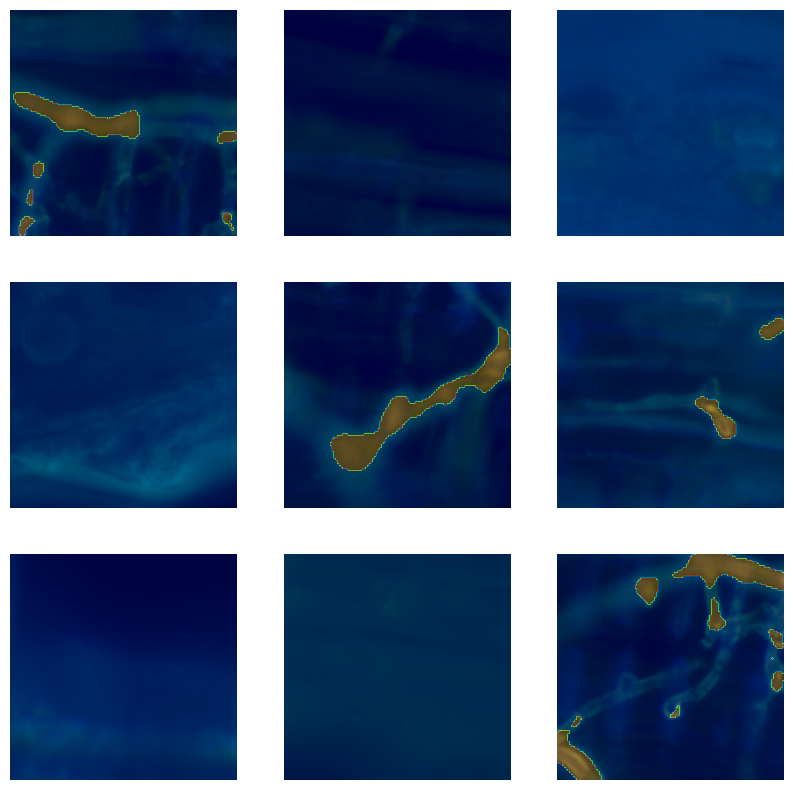

In [9]:
# Displayig Sample Predictions
def display_sample_predictions(model, X_test, y_test):
    preds = model.predict(X_test)
    preds = (preds > 0.5).astype(np.uint8)  # Convert to binary mask
    
    fig, axes = plt.subplots(3, 3, figsize=(10, 10))
    for i in range(9):
        ax = axes[i//3, i%3]
        ax.imshow(X_test[i])
        ax.imshow(preds[i].squeeze(), cmap="jet", alpha=0.5)  # Overlay prediction
        ax.axis("off")
    plt.show()

display_sample_predictions(best_model, X_test, y_test)

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns

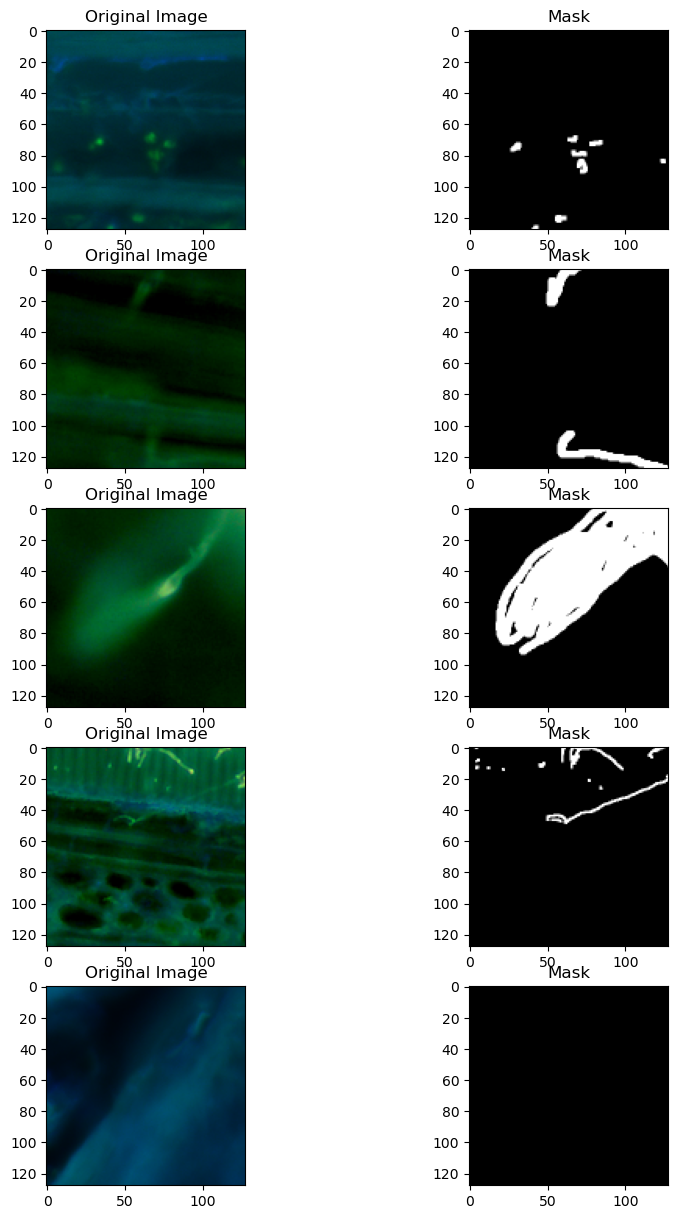

C:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


In [ ]:
# Display Sample Images & Masks
def display_samples(X, y, num_samples=5):
    fig, axes = plt.subplots(num_samples, 2, figsize=(10, num_samples * 3))
    for i in range(num_samples):
        axes[i, 0].imshow(X[i])
        axes[i, 0].set_title("Original Image")
        axes[i, 1].imshow(y[i].squeeze(), cmap='gray')
        axes[i, 1].set_title("Mask")
    plt.show()

display_samples(X_train, y_train)

# Pixel Intensity Distribution
plt.figure(figsize=(6, 4))
sns.histplot(X_train.flatten(), bins=50, kde=True, color='blue')
plt.title("Pixel Intensity Distribution")
plt.show()

